#Görev Tanımı
Bu görevde, verilen ahşap yüzey verileri kullanılarak denetimsiz öğrenme (unsupervised learning) yaklaşımıyla bir anomali tespit modeli geliştirilecektir. Model, ahşap yüzeyinde kusurların veya düzensizliklerin tespit edilmesi için eğitilecektir.


#1. Ön İşleme Adımları ve Veri Hazırlığı

In [55]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import os

print("Lütfen JPG dosyalarınızı seçin...")
uploaded_files = files.upload()


Lütfen JPG dosyalarınızı seçin...


Saving 1.jpg to 1 (27).jpg


###Arka Planı Kaldırma


In [56]:
def remove_dark_background(image_path, threshold=50):
    # Resmi yükle
    img = cv2.imread(image_path)
    if img is None:
        print(f"Hata: {image_path} yüklenemedi!")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Koyu renkleri belirlemek için eşikleme işlemi
    _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Gürültüleri temizlemek için morfolojik işlemler
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Koyu alanları daha iyi kapatır
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Küçük gürültüleri temizler

    # Konturları bul ve en büyük alanı içeren dikdörtgeni belirle
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("Ahşap kısmı tespit edilemedi!")
        return img

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

    # Kırpılmış resmi al
    cropped = img[y:y+h, x:x+w]

    return cropped


###Görüntü Normalizasyonu ve Boyutlandırma

Resim: 1 (27).jpg


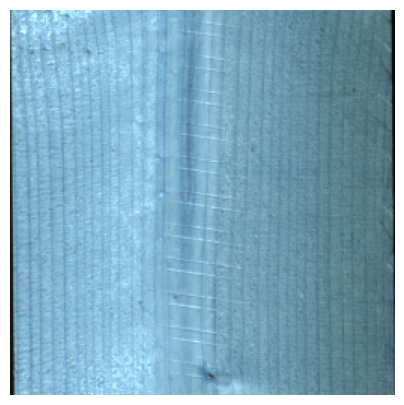

In [60]:
for filename in uploaded_files.keys():
    file_path = os.path.join("/content", filename)
    cleaned_image = remove_dark_background(file_path)

    if cleaned_image is not None:
        # Görüntüyü 256x256 boyutuna yeniden boyutlandır
        resized_image = cv2.resize(cleaned_image, (256, 256))

        # Piksel değerlerini [0,1] aralığına normalize et
        normalized_image = resized_image.astype(np.float32) / 255.0

        # Kaydetme işlemi için 0-255 ölçeğine geri döndürme (opsiyonel)
        output_image = (normalized_image * 255).astype(np.uint8)

        output_path = os.path.join("/content", "cleaned_" + filename)
        cv2.imwrite(output_path, output_image)
        print(f"Resim: {filename}")

        # Ekranda göster
        plt.figure(figsize=(5,5))
        plt.imshow(normalized_image)
        plt.axis('off')
        plt.show()